In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.precision', 3)

The goal of the project is predict with high accuracy survival of heart failure patients based on the provided features.

In [2]:
df = pd.read_csv('heart_failure_clinical_records_dataset.csv',delimiter=',',header=0)
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [3]:
# Upon inspecting the csv file, all featrues should be of int type except for serum_creatinine.
# Let us build a dictionary to map each feature to a corresponding data type.

columns = list(df.columns)
dtypes = {column: np.int64 for column in columns}

# Make sure serum_creatinine is of float
dtypes['serum_creatinine'] = np.float64
df = df.astype(dtypes)

In [4]:
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75,0,582,0,20,1,265000,1.9,130,1,0,4,1
1,55,0,7861,0,38,0,263358,1.1,136,1,0,6,1
2,65,0,146,0,20,0,162000,1.3,129,1,1,7,1
3,50,1,111,0,20,0,210000,1.9,137,1,0,7,1
4,65,1,160,1,20,0,327000,2.7,116,0,0,8,1


In [5]:
## There may be potential data leak from the time feature for the reason provided in the report. We shall drop it.
df.loc[df['time'] < 60, 'DEATH_EVENT'].value_counts()

1    52
0     8
Name: DEATH_EVENT, dtype: int64

In [6]:
df.drop(columns=['time'], inplace=True)

# Task 1: Retrieving and Preparing the Data

Even though missing values do not exist in this dataset according to UCI Machine Learning Repository, we shall confirm there are indeed no missing values.

## Missing Values

In [7]:
df[df.isna().any(axis=1)]

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,DEATH_EVENT


Indeed, there are no missing values as indicated on the website.

There are 6 binary attributes including the target whose values should be either 0 or 1. We shall check whether that is the case.

In [8]:
binary_attributes = ['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking', 'DEATH_EVENT']

isBinary = True
for binary_attribute in binary_attributes:
    # Return a list of unique values
    lst = df[binary_attribute].unique()
    # If the list is not made of 0 and 1
    # Set res to False.
    if not (len(lst) == 2 and 0 in lst and 1 in lst):
        isBinary = False
print(isBinary)
        

True


They indeed contain only two values as expected of a binary attribute.

## Data Types and Redundant Whitespace

In [9]:
df.dtypes

age                           int64
anaemia                       int64
creatinine_phosphokinase      int64
diabetes                      int64
ejection_fraction             int64
high_blood_pressure           int64
platelets                     int64
serum_creatinine            float64
serum_sodium                  int64
sex                           int64
smoking                       int64
DEATH_EVENT                   int64
dtype: object

As all the attributes are numerical types, they cannot contain values with whitespace.

We shall further check whether the dataset is free of human-generated typos and impossible values by means of descriptive statistics in the next step of the project: Data Exploration

# Task 2: Data Exploration

## 2-1 Explore Each Column

### Numerical Attributes

In [10]:
# Extract the names of numerical attributes given the names of binary variables
numerical_attributes = sorted(list(set(list(df.columns)) - set(binary_attributes)))

#### Impossible Values and Sanity Checks

Let us now inspect the descriptive statistics of the numerical attributes to confirm there are no impossible values.

In [11]:
df[numerical_attributes].describe()

,age,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium
count,299.000,299.000,299.000,299.000,299.000,299.000
mean,60.829,581.839,38.084,263358.027,1.394,136.625
std,11.895,970.288,11.835,97804.237,1.035,4.412
min,40.000,23.000,14.000,25100.000,0.500,113.000
25%,51.000,116.500,30.000,212500.000,0.900,134.000
50%,60.000,250.000,38.000,262000.000,1.100,137.000
75%,70.000,582.000,45.000,303500.000,1.400,140.000
max,95.000,7861.000,80.000,850000.000,9.400,148.000


In [12]:
df.dtypes

age                           int64
anaemia                       int64
creatinine_phosphokinase      int64
diabetes                      int64
ejection_fraction             int64
high_blood_pressure           int64
platelets                     int64
serum_creatinine            float64
serum_sodium                  int64
sex                           int64
smoking                       int64
DEATH_EVENT                   int64
dtype: object

Let us now plot a box-plot for each of the numerical attributes so that the numbers above are easier to understand via visual representations.

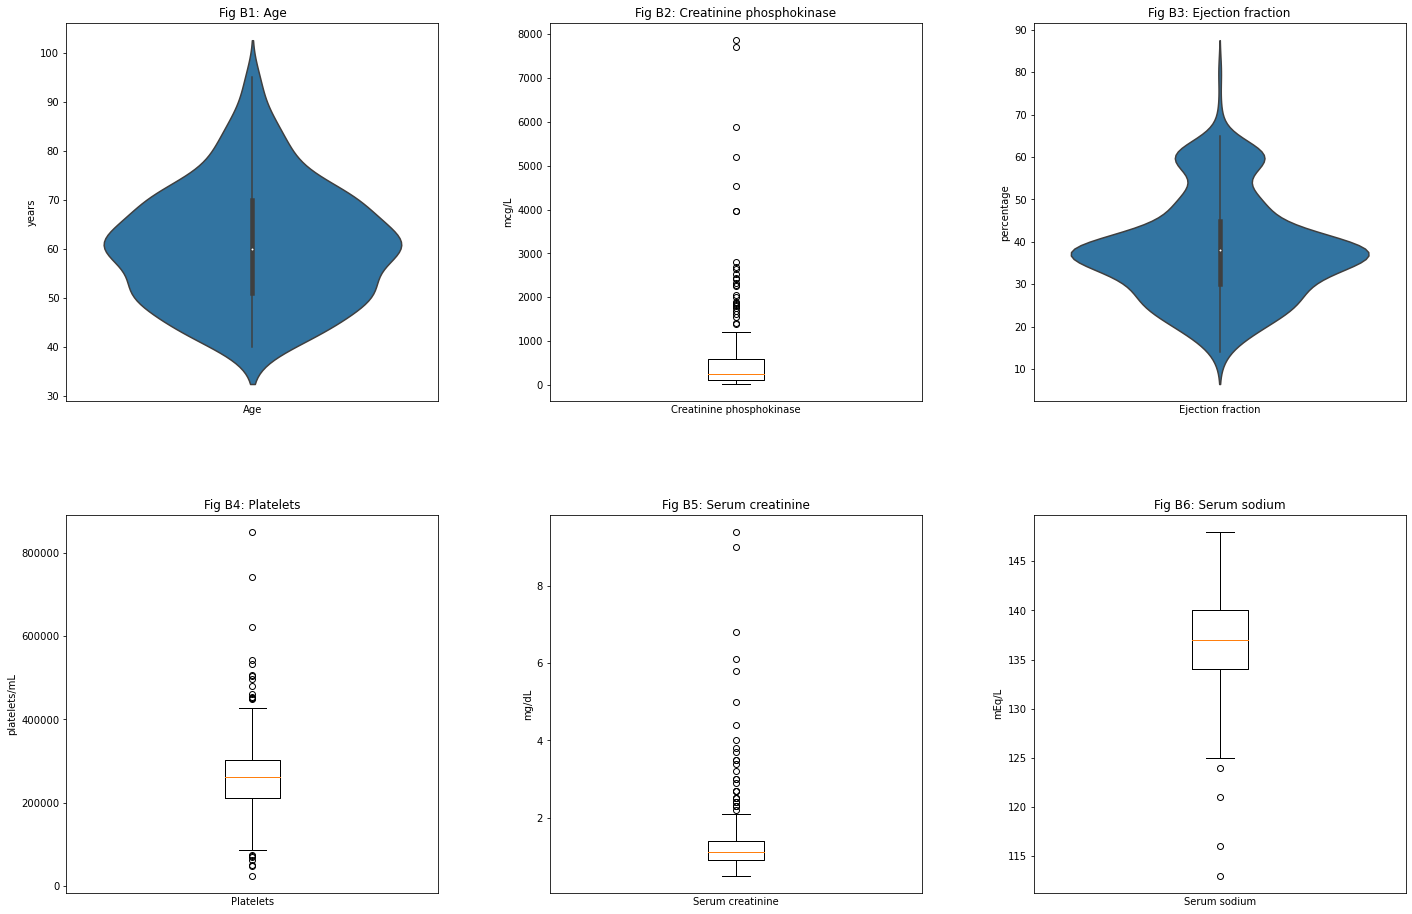

In [13]:
num_rows = 2
num_cols = 3
total_plots = num_rows * num_cols

fig, axs = plt.subplots(num_rows, num_cols, figsize=(24,16))
grid = plt.GridSpec(num_rows,num_cols,wspace=0.3,hspace=0.3)

# Create a list that contains units of mearuement for each of the numerical columns
units = ['years', 'mcg/L', 'percentage', 'platelets/mL', 'mg/dL', 'mEq/L', 'days']
violinplot_attributes = ['age', 'ejection_fraction', 'time']

# Plot each box-plot iteratively
for i in range(total_plots):
    row_idx = i // num_cols
    col_idx = i % num_cols
    plt.subplot(grid[row_idx, col_idx])
    # Plot violion plots for attributes without many outliers
    if numerical_attributes[i] in violinplot_attributes:
        sns.violinplot(data=df[numerical_attributes].iloc[:,i])
    else:
        plt.boxplot(df[numerical_attributes].iloc[:,i])

    # Add labels for the x-axis and y-axis as well as the title
    title = ' '.join(numerical_attributes[i].split('_')).capitalize()
    plt.xlabel(title)
    plt.ylabel(units[i])
    plt.title('Fig B' + str(i + 1) + ': ' + title)
    # Remove x ticks
    plt.xticks([])

plt.show()

### Binary Attributes

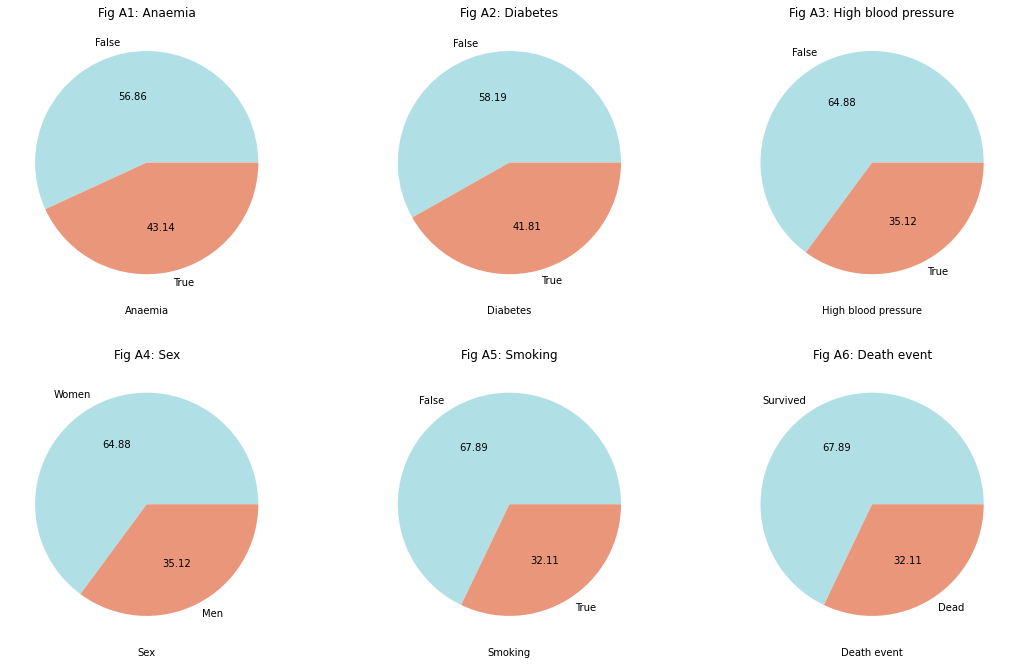

In [14]:
num_rows = 2
num_cols = 3
total_plots = num_rows * num_cols

fig, axs = plt.subplots(num_rows, num_cols, figsize=(18,12))
grid = plt.GridSpec(num_rows,num_cols,wspace=0.3,hspace=0.1)
# Create labels for each pie chart
labels = [['False', 'True'], ['False', 'True'], ['False', 'True'],
          ['Women', 'Men'], ['False', 'True'], ['Survived', 'Dead'] ]

# Plot each pie-chart iteratively
for i in range(total_plots):
    row_idx = i // num_cols
    col_idx = i % num_cols
    plt.subplot(grid[row_idx, col_idx])
    # Plot violion plots for attributes without many outliers
    df[binary_attributes[i]].value_counts().plot(kind='pie', autopct='%.2f', labels=labels[i], colors=['powderblue','darksalmon'])
    
    # Add labels for the x-axis and y-axis as well as the title
    title = ' '.join(binary_attributes[i].split('_')).capitalize()
    plt.xlabel(title)
    plt.ylabel('')
    plt.title('Fig A' + str(i + 1) + ': ' + title)
    # Remove x ticks
    plt.xticks([])

plt.show()

## 2-2 Explore Pairs of Columns

### Numerical Attributes & Survival Status

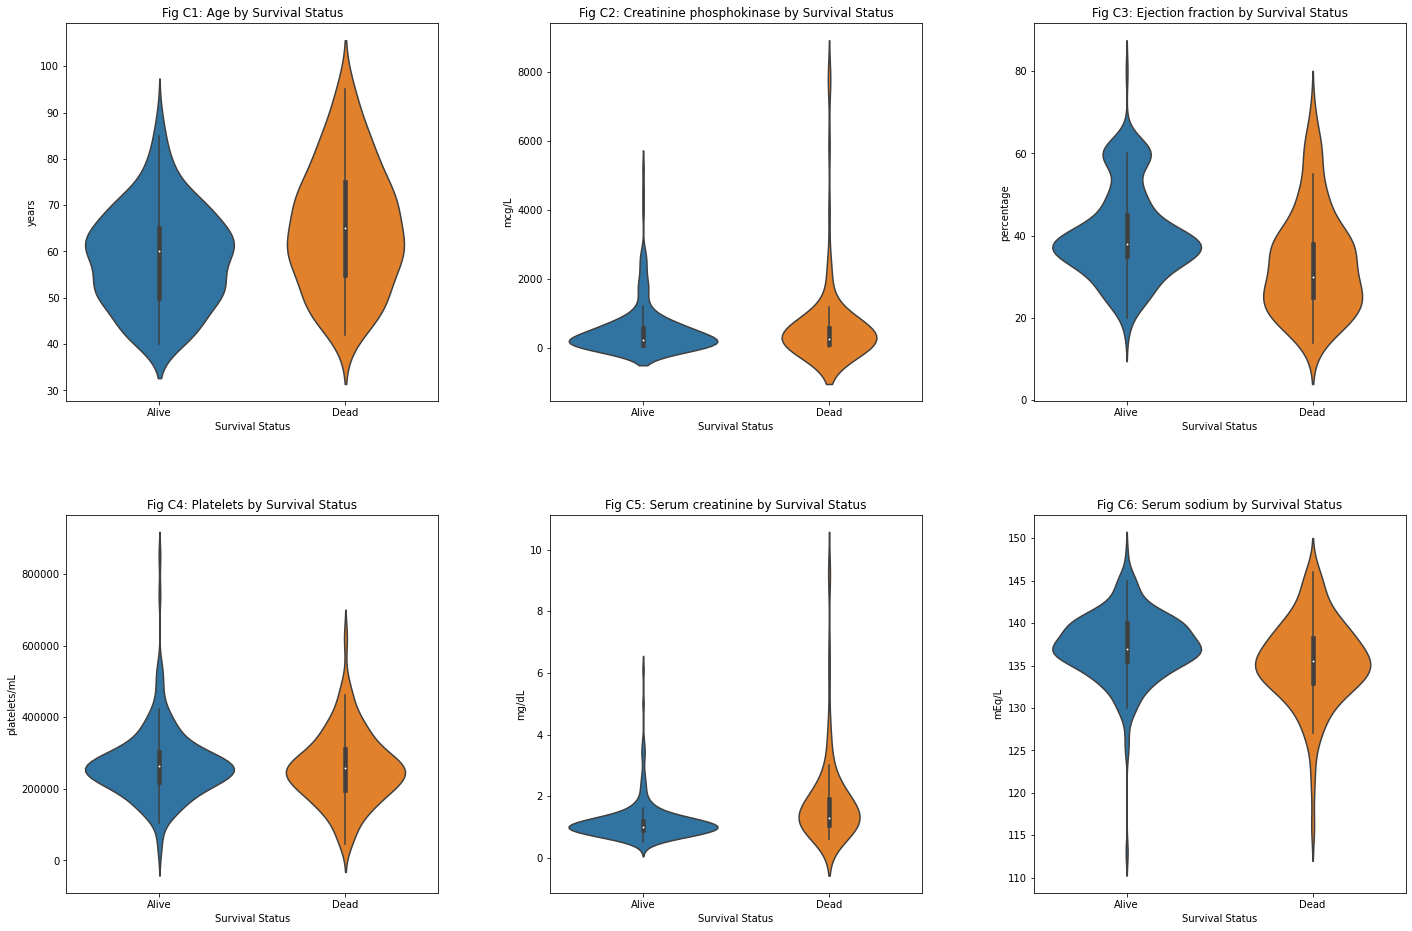

In [15]:
num_rows = 2
num_cols = 3
total_plots = num_rows * num_cols

fig, axs = plt.subplots(num_rows, num_cols, figsize=(24,16))
grid = plt.GridSpec(num_rows,num_cols,wspace=0.3,hspace=0.3)

# Create a list that contains units of mearuement for each of the numerical columns
units = ['years', 'mcg/L', 'percentage', 'platelets/mL', 'mg/dL', 'mEq/L', 'days']

# Plot each box-plot iteratively
for i in range(total_plots):
    row_idx = i // num_cols
    col_idx = i % num_cols
    plt.subplot(grid[row_idx, col_idx])

    sns.violinplot(x=df['DEATH_EVENT'],y=df[numerical_attributes].iloc[:,i])

    # Add labels for the x-axis and y-axis as well as the title
    title = ' '.join(numerical_attributes[i].split('_')).capitalize()
    plt.xlabel('Survival Status')
    plt.ylabel(units[i])
    plt.title('Fig C' + str(i + 1) + ': ' + title + ' by Survival Status')
    plt.xticks(ticks=[0,1], labels=['Alive', 'Dead'])

plt.show()

### Numerical Attributes & Binary Attributes by Survival Status

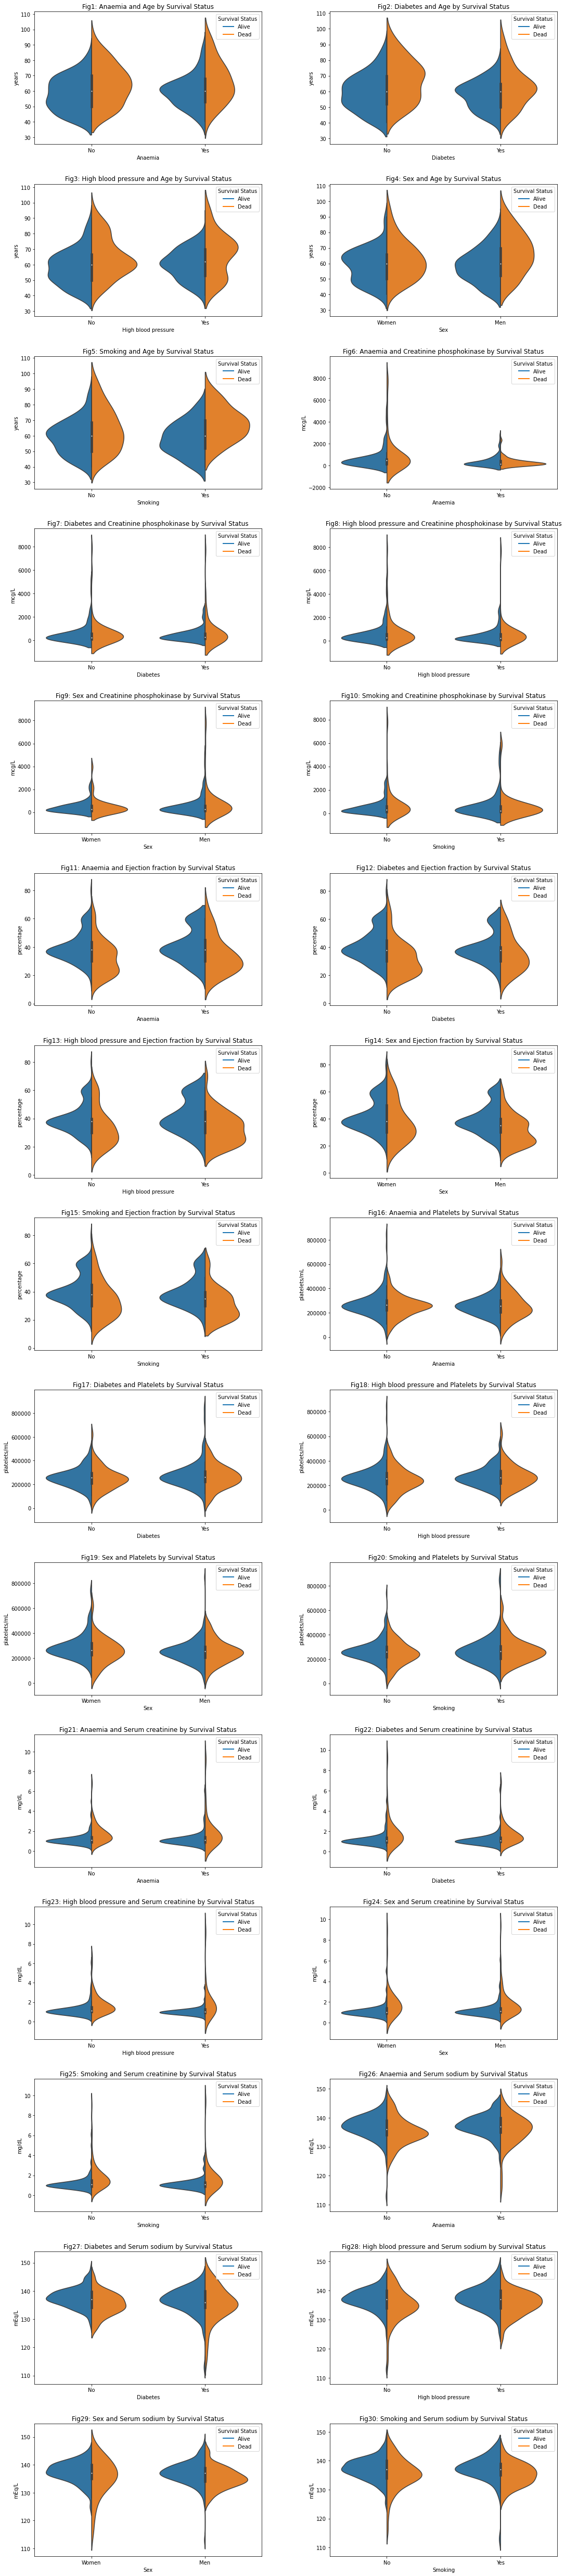

In [16]:
num_rows = 15
num_cols = 2
total_plots = num_rows * num_cols
num_numerical_attributes = 6
num_binary_attributes = 5

fig, axs = plt.subplots(num_rows, num_cols, figsize=(18,18*5))
grid = plt.GridSpec(num_rows,num_cols,wspace=0.3,hspace=0.3)

# Create a list that contains units of mearuement for each of the numerical columns
units = ['years', 'mcg/L', 'percentage', 'platelets/mL', 'mg/dL', 'mEq/L', 'days']

# Plot each box-plot iteratively
plot_idx = 0
for i in range(num_numerical_attributes):
    for j in range(num_binary_attributes):
        row_idx = plot_idx // num_cols
        col_idx = plot_idx % num_cols
        plt.subplot(grid[row_idx, col_idx])

        sns.violinplot(x=df[binary_attributes[j]],y=df[numerical_attributes].iloc[:,i], 
                       hue=df['DEATH_EVENT'], split=True, legend=False)

        # Add labels for the x-axis and y-axis as well as the title
        xlabel = ' '.join(binary_attributes[j].split('_')).capitalize()
        ylabel = ' '.join(numerical_attributes[i].split('_')).capitalize()
        title = 'Fig' + str(plot_idx + 1) + ': ' + xlabel + ' and ' + ylabel + ' by Survival Status'
        plt.xlabel(xlabel)
        plt.ylabel(units[i])
        plt.title(title)
        if (binary_attributes[j] == 'sex'):
            plt.xticks(ticks=[0,1], labels=['Women', 'Men'])
        else:
            plt.xticks(ticks=[0,1], labels=['No', 'Yes'])
        
        plot_idx += 1
        plt.legend(title='Survival Status', loc='upper right', labels=['Alive', 'Dead'])
        ax = plt.gca()
        leg = ax.get_legend()
        leg.legendHandles[0].set_color('C0')
        leg.legendHandles[0].set_linewidth(2.0)
        leg.legendHandles[1].set_color('C1')
        leg.legendHandles[1].set_linewidth(2.0)

plt.show()

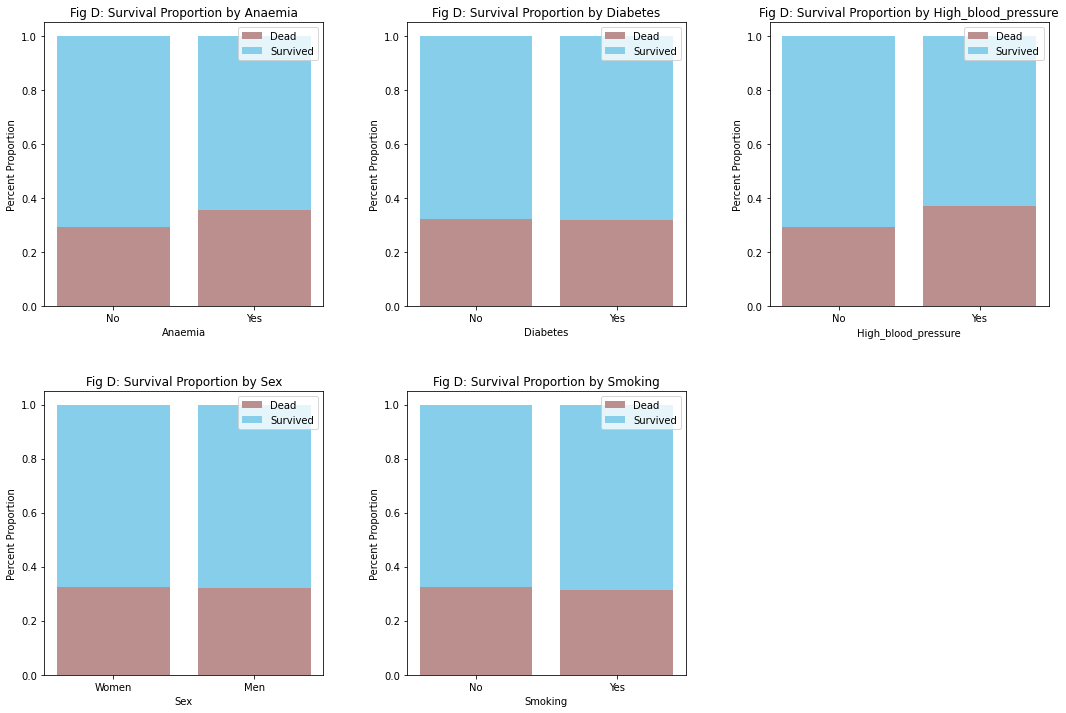

In [17]:
num_rows = 2
num_cols = 3
total_plots = num_rows * num_cols - 1

fig, axs = plt.subplots(num_rows, num_cols, figsize=(18,12))
grid = plt.GridSpec(num_rows,num_cols,wspace=0.3,hspace=0.3)
dfs = []

for i in range(total_plots):
    # Create a Pandas DataFrame using groupby on the current binary feature and get a mean value for each of the values
    # For example, if the current binary feature is smoking, this will create the percentage of survival for both smoker and non-smoker
    df_test = df.groupby(binary_attributes[i])[['DEATH_EVENT']].mean()
    # Change the name of a column to Survived for readability
    df_test.rename(columns={'DEATH_EVENT': 'Dead'}, inplace=True)
    # Create another column called Dead so that a stacked bar graph can be visualised
    df_test['Survived'] = 1 - df_test['Dead']
    dfs.append(df_test)
    

labels = ['No', 'Yes']
# Plot each pie-chart iteratively
for i in range(total_plots):
    row_idx = i // num_cols
    col_idx = i % num_cols
    plt.subplot(grid[row_idx, col_idx])
    ax = plt.gca()
    ax.bar(labels, dfs[i]['Dead'], label='Dead', color='rosybrown')
    ax.bar(labels, dfs[i]['Survived'], bottom=dfs[i]['Dead'], label='Survived', color='skyblue')
    ax.legend()
    if binary_attributes[i] == 'sex':
        plt.xticks(ticks=[0,1], labels=['Women', 'Men'], rotation='horizontal')
    else:
        plt.xticks(ticks=[0,1], labels=['No', 'Yes'], rotation='horizontal')
    plt.title('Fig D: Survival Proportion by ' + dfs[i].index.name.capitalize() )
        

    plt.ylabel('Percent Proportion')
    plt.xlabel(dfs[i].index.name.capitalize())
fig.delaxes(axs[num_rows - 1][num_cols - 1])
plt.show()

# Task 3: Data Modelling

First thing first, let's extract the target feature from df and remove the time feature for the reason mentioned above.

In [18]:
target = df['DEATH_EVENT']
df.drop(columns=['DEATH_EVENT'], inplace=True)

In [19]:
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking
0,75,0,582,0,20,1,265000,1.9,130,1,0
1,55,0,7861,0,38,0,263358,1.1,136,1,0
2,65,0,146,0,20,0,162000,1.3,129,1,1
3,50,1,111,0,20,0,210000,1.9,137,1,0
4,65,1,160,1,20,0,327000,2.7,116,0,0


In [20]:
target

0      1
1      1
2      1
3      1
4      1
      ..
294    0
295    0
296    0
297    0
298    0
Name: DEATH_EVENT, Length: 299, dtype: int64

Let's split the dataset into a 75% training set and a 25% test set.

In [21]:
from sklearn.model_selection import train_test_split
# The default train_size is 0.25Hoonie Sun
X_train, X_test, y_train, y_test = train_test_split(df, target)

## k-Nearest Neighbors

In [22]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

In [23]:
# clf = KNeighborsClassifier(n_neighbors=1, weights='distance', p=10000)
clf = KNeighborsClassifier(5)
fit = clf.fit(X_train, y_train)
predicted = fit.predict(X_test)
cm = confusion_matrix(y_test, predicted)
print(cm)
print(cm[1][0])
print(cm[1][1])
print('Accuracy:', clf.score(X_test, y_test))
from sklearn.metrics import classification_report
print(classification_report(y_test, predicted))

[[44  9]
 [16  6]]
16
6
Accuracy: 0.6666666666666666
              precision    recall  f1-score   support

           0       0.73      0.83      0.78        53
           1       0.40      0.27      0.32        22

    accuracy                           0.67        75
   macro avg       0.57      0.55      0.55        75
weighted avg       0.64      0.67      0.65        75



As seen above, the accuracy for the model is suboptimal regardless of what values are passed into the parameters. The poor accuracy is then most likely due to the inclusion of unnecessary features. 

### Feature Selection - Hill Climbing

In [24]:
from sklearn.utils import shuffle

In [25]:
from sklearn.utils import shuffle
X = df.to_numpy() 

col_num = X.shape[1]

global_max_score = 0.0
global_i = 0
feature_freq = {}
num_iterations = 50
# As Hill Climbing produces a local maximum solution,
# run the algorithm multiple times to find a near global-maximum solution
for i in range(num_iterations):
    print(i,'th')
    col_ind_random = shuffle(range(0,col_num), random_state=i)
    local_max_score = 0.0
    new_ind = []
    for cur_f in range(0, col_num):
        col_idx = col_ind_random[cur_f]
        new_ind.append(col_idx)
        new_data = X[:,new_ind].copy()
        X_train, X_test, y_train, y_test = train_test_split(new_data, target, test_size=0.25)
        clf = KNeighborsClassifier(5)
        fit = clf.fit(X_train, y_train)
        curr_score = clf.score(X_test, y_test)
        if curr_score <= local_max_score:
            new_ind.remove(col_ind_random[cur_f])
        else:
            local_max_score = curr_score
            feature_name = list(df.columns)[col_idx]
            print('Current feature name: ' + feature_name)
            if feature_name not in feature_freq:
                feature_freq[feature_name] = 0
            else:
                feature_freq[feature_name] += 1
            print("Score with " + str(len(new_ind)) + " selected featrues: " + str(curr_score))
    if local_max_score > global_max_score:
        global_max_score = local_max_score
        global_i = i
print(global_max_score, global_i)
print(feature_freq)
        
    

0 th
Current feature name: ejection_fraction
Score with 1 selected featrues: 0.68
Current feature name: sex
Score with 2 selected featrues: 0.7066666666666667
Current feature name: anaemia
Score with 3 selected featrues: 0.7333333333333333
Current feature name: serum_creatinine
Score with 4 selected featrues: 0.7866666666666666
Current feature name: serum_sodium
Score with 5 selected featrues: 0.8133333333333334
1 th
Current feature name: creatinine_phosphokinase
Score with 1 selected featrues: 0.5466666666666666
Current feature name: diabetes
Score with 2 selected featrues: 0.6133333333333333
Current feature name: ejection_fraction
Score with 3 selected featrues: 0.7333333333333333
2 th
Current feature name: ejection_fraction
Score with 1 selected featrues: 0.64
Current feature name: anaemia
Score with 2 selected featrues: 0.7466666666666667
3 th
Current feature name: high_blood_pressure
Score with 1 selected featrues: 0.6933333333333334
Current feature name: serum_creatinine
Score wi

Current feature name: ejection_fraction
Score with 3 selected featrues: 0.6933333333333334
Current feature name: serum_creatinine
Score with 4 selected featrues: 0.7066666666666667
33 th
Current feature name: age
Score with 1 selected featrues: 0.56
Current feature name: smoking
Score with 2 selected featrues: 0.6266666666666667
Current feature name: diabetes
Score with 3 selected featrues: 0.68
Current feature name: anaemia
Score with 4 selected featrues: 0.72
Current feature name: ejection_fraction
Score with 5 selected featrues: 0.7466666666666667
34 th
Current feature name: age
Score with 1 selected featrues: 0.64
Current feature name: smoking
Score with 2 selected featrues: 0.68
Current feature name: serum_creatinine
Score with 3 selected featrues: 0.7733333333333333
35 th
Current feature name: high_blood_pressure
Score with 1 selected featrues: 0.49333333333333335
Current feature name: creatinine_phosphokinase
Score with 2 selected featrues: 0.5733333333333334
Current feature nam

In [26]:
# Extract the three most frequently selected featrues
selected_features = [k for k, v in sorted(feature_freq.items(), key=lambda item: item[1])][:-4:-1]

In [27]:
# For automating this process, the line below is added. However, it takes a long time to run the loop above 50,000
# times. Therefore, the feature names below are hard-coded. 
# featured_selected_df = df[selected_features]
selected_features = ['ejection_fraction','serum_creatinine', 'serum_sodium' ]
feature_selected_df = df[selected_features]

### Plotting the Selected Features

In [28]:
import matplotlib.patches as mpatches

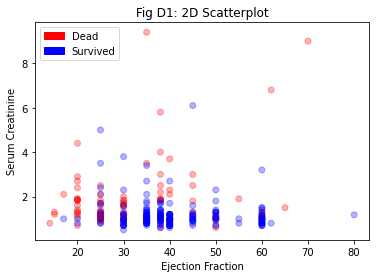

In [29]:
red_patch = mpatches.Patch(color='red', label='Dead', hatch='o')
blue_patch = mpatches.Patch(color='blue', label='Survived', hatch='o')
colors_palette = {0: 'blue', 1:'red'}
colors = [colors_palette[c] for c in target]
plt.scatter(feature_selected_df.iloc[:,0], feature_selected_df.iloc[:,1], c=colors, alpha=0.3)
plt.xlabel(' '.join([word.capitalize() for word in list(feature_selected_df.columns)[0].split('_')]))
plt.ylabel(' '.join([word.capitalize() for word in list(feature_selected_df.columns)[1].split('_')]))
plt.title('Fig D1: 2D Scatterplot')
plt.legend(handles=[red_patch, blue_patch])
plt.show()

<IPython.core.display.Javascript object>


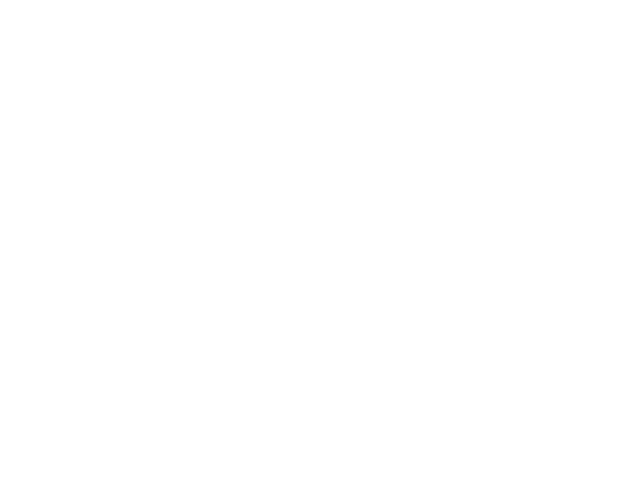

In [30]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D

sns.set(style = "darkgrid")

colors_palette = {0: 'blue', 1:'red'}
colors = [colors_palette[c] for c in target]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = df['ejection_fraction']
y = df['serum_creatinine']
z = df['serum_sodium']

ax.set_xlabel("Ejection Fraction")
ax.set_ylabel("Serum Creatinine")
ax.set_zlabel("Serum Sodium")

ax.scatter(x, y, z, c=colors, alpha=0.2)

###  The Number of Neighbours

In [31]:
feature_selected_df['ejection_fraction'].value_counts()

35    49
38    40
40    37
25    36
30    34
60    31
50    21
45    20
20    18
55     3
15     2
62     2
17     2
65     1
14     1
80     1
70     1
Name: ejection_fraction, dtype: int64

In [32]:
feature_selected_df['ejection_fraction'].value_counts().mean()

17.58823529411765

### Leave-1 out Cross Validation

In [33]:
clf = KNeighborsClassifier(17, weights='distance', p=2)
from sklearn.model_selection import KFold
kf = KFold(n_splits=feature_selected_df.shape[0], shuffle=True)
 
total_positive = 0
total_negative = 0
cms = np.zeros((2,2))
predicted_vals = [0] * feature_selected_df.shape[0]
for k, (train_index, test_index) in enumerate(kf.split(feature_selected_df)):
    X_train, X_test = feature_selected_df.iloc[train_index], feature_selected_df.iloc[test_index]
    y_train, y_test = target.iloc[train_index], target.iloc[test_index]
    fit = clf.fit(X_train, y_train)
    predicted = fit.predict(X_test)
    # store the predicted value 
    predicted_vals[test_index[0]] = predicted[0]
    cm = confusion_matrix(y_test, predicted, labels=[False,True])
    if cm[0][0] == 1:
        total_negative += 1
    if cm[1][1] == 1:
        total_positive += 1
    cms += cm 
print("Table A1: k-Nearest Neighbour Model\n")
print('Accuracy: {:.2f}'.format((total_negative + total_positive) / feature_selected_df.shape[0]))
pd.DataFrame(cms, columns=['Predicted: NO', 'Predicted: YES'], index=['Actual: NO', 'Actual: YES'])


Table A1: k-Nearest Neighbour Model

Accuracy: 0.73


,Predicted: NO,Predicted: YES
Actual: NO,176.0,27.0
Actual: YES,55.0,41.0


### Errors plotted

<IPython.core.display.Javascript object>


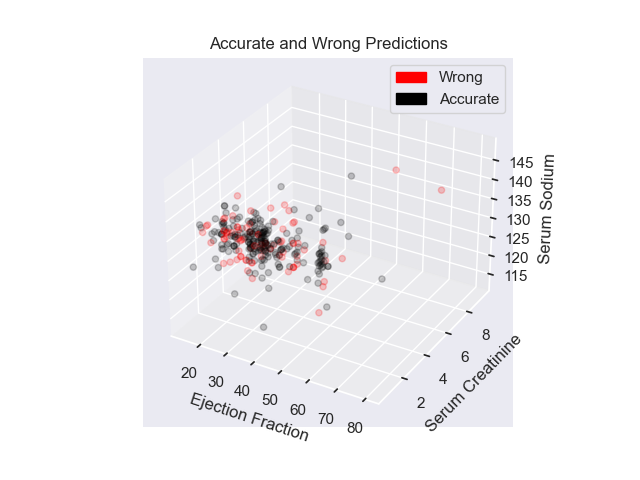

In [34]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D

correct_results = np.array(predicted_vals) == target.to_numpy()

colors_palette = {True: 'black', False:'red'}
colors = [colors_palette[res] for res in correct_results]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = df['ejection_fraction']
y = df['serum_creatinine']
z = df['serum_sodium']

ax.set_xlabel("Ejection Fraction")
ax.set_ylabel("Serum Creatinine")
ax.set_zlabel("Serum Sodium")
ax.set_title("Accurate and Wrong Predictions")
red_patch = mpatches.Patch(color='red', label='Wrong', hatch='o')
blue_patch = mpatches.Patch(color='black', label='Accurate', hatch='o')
plt.legend(handles=[red_patch, blue_patch])

ax.scatter(x, y, z, c=colors, alpha=0.2)

## Decision Tree

In [35]:
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
max_min_samples_split = 40
max_min_samples_leaf = 20
num_iterations = 100
for i in range(2, max_min_samples_leaf + 1):
    for j in range(1, max_min_samples_split + 1):
        accuracy_scores = np.zeros((max_min_samples_leaf + 1,max_min_samples_split + 1))
        for k in range(num_iterations):
            X_train, X_test, y_train, y_test = train_test_split(df, target)
            clf = DecisionTreeClassifier(max_depth=None, min_samples_split=i, min_samples_leaf=j)
            fit = clf.fit(X_train, y_train)
            y_pre = fit.predict(X_test)
            accuracy_scores[i][j] += accuracy_score(y_test, y_pre)
        accuracy_scores[i][j] /= num_iterations
        print("i", i, "j", j, "accuracy_score", accuracy_scores[i][j])

i 2 j 1 accuracy_score 0.6777333333333331
i 2 j 2 accuracy_score 0.6843999999999997
i 2 j 3 accuracy_score 0.6841333333333331
i 2 j 4 accuracy_score 0.6921333333333333
i 2 j 5 accuracy_score 0.7011999999999997
i 2 j 6 accuracy_score 0.7209333333333333
i 2 j 7 accuracy_score 0.7259999999999996
i 2 j 8 accuracy_score 0.7305333333333336
i 2 j 9 accuracy_score 0.7385333333333332
i 2 j 10 accuracy_score 0.7373333333333336
i 2 j 11 accuracy_score 0.7226666666666667
i 2 j 12 accuracy_score 0.7263999999999997
i 2 j 13 accuracy_score 0.7343999999999998
i 2 j 14 accuracy_score 0.7373333333333335
i 2 j 15 accuracy_score 0.7347999999999999
i 2 j 16 accuracy_score 0.7290666666666668
i 2 j 17 accuracy_score 0.7396
i 2 j 18 accuracy_score 0.7493333333333334
i 2 j 19 accuracy_score 0.7426666666666667
i 2 j 20 accuracy_score 0.7446666666666667
i 2 j 21 accuracy_score 0.7494666666666666
i 2 j 22 accuracy_score 0.7477333333333337
i 2 j 23 accuracy_score 0.7434666666666664
i 2 j 24 accuracy_score 0.747599

i 6 j 37 accuracy_score 0.7134666666666668
i 6 j 38 accuracy_score 0.7049333333333331
i 6 j 39 accuracy_score 0.7072000000000003
i 6 j 40 accuracy_score 0.715333333333333
i 7 j 1 accuracy_score 0.6862666666666668
i 7 j 2 accuracy_score 0.6917333333333332
i 7 j 3 accuracy_score 0.6757333333333332
i 7 j 4 accuracy_score 0.6959999999999994
i 7 j 5 accuracy_score 0.7056
i 7 j 6 accuracy_score 0.718
i 7 j 7 accuracy_score 0.7226666666666663
i 7 j 8 accuracy_score 0.7245333333333335
i 7 j 9 accuracy_score 0.7337333333333333
i 7 j 10 accuracy_score 0.7353333333333332
i 7 j 11 accuracy_score 0.7262666666666666
i 7 j 12 accuracy_score 0.7304
i 7 j 13 accuracy_score 0.7282666666666667
i 7 j 14 accuracy_score 0.7315999999999998
i 7 j 15 accuracy_score 0.7334666666666664
i 7 j 16 accuracy_score 0.7364000000000002
i 7 j 17 accuracy_score 0.7445333333333336
i 7 j 18 accuracy_score 0.7397333333333331
i 7 j 19 accuracy_score 0.7382666666666664
i 7 j 20 accuracy_score 0.7482666666666664
i 7 j 21 accura

i 11 j 32 accuracy_score 0.7192000000000001
i 11 j 33 accuracy_score 0.7222666666666666
i 11 j 34 accuracy_score 0.7153333333333335
i 11 j 35 accuracy_score 0.7113333333333336
i 11 j 36 accuracy_score 0.7070666666666665
i 11 j 37 accuracy_score 0.7129333333333332
i 11 j 38 accuracy_score 0.7118666666666665
i 11 j 39 accuracy_score 0.7158666666666668
i 11 j 40 accuracy_score 0.7029333333333334
i 12 j 1 accuracy_score 0.6925333333333336
i 12 j 2 accuracy_score 0.7037333333333333
i 12 j 3 accuracy_score 0.7065333333333333
i 12 j 4 accuracy_score 0.7076
i 12 j 5 accuracy_score 0.7118666666666669
i 12 j 6 accuracy_score 0.7198666666666669
i 12 j 7 accuracy_score 0.727733333333333
i 12 j 8 accuracy_score 0.7346666666666666
i 12 j 9 accuracy_score 0.729333333333333
i 12 j 10 accuracy_score 0.7319999999999998
i 12 j 11 accuracy_score 0.7232
i 12 j 12 accuracy_score 0.7301333333333331
i 12 j 13 accuracy_score 0.7330666666666664
i 12 j 14 accuracy_score 0.7313333333333334
i 12 j 15 accuracy_scor

i 16 j 23 accuracy_score 0.7529333333333332
i 16 j 24 accuracy_score 0.7397333333333336
i 16 j 25 accuracy_score 0.7452000000000002
i 16 j 26 accuracy_score 0.7366666666666665
i 16 j 27 accuracy_score 0.7414666666666667
i 16 j 28 accuracy_score 0.7265333333333334
i 16 j 29 accuracy_score 0.7281333333333332
i 16 j 30 accuracy_score 0.7245333333333331
i 16 j 31 accuracy_score 0.7265333333333334
i 16 j 32 accuracy_score 0.7170666666666667
i 16 j 33 accuracy_score 0.718
i 16 j 34 accuracy_score 0.7253333333333335
i 16 j 35 accuracy_score 0.727733333333333
i 16 j 36 accuracy_score 0.7193333333333335
i 16 j 37 accuracy_score 0.7178666666666669
i 16 j 38 accuracy_score 0.7138666666666664
i 16 j 39 accuracy_score 0.7106666666666664
i 16 j 40 accuracy_score 0.7095999999999998
i 17 j 1 accuracy_score 0.7057333333333335
i 17 j 2 accuracy_score 0.7187999999999997
i 17 j 3 accuracy_score 0.7159999999999996
i 17 j 4 accuracy_score 0.7222666666666665
i 17 j 5 accuracy_score 0.7257333333333333
i 17 j 

### Leave-1 out Cross Validation

In [36]:
clf = DecisionTreeClassifier(max_depth=4, min_samples_split=2, min_samples_leaf=19)
from sklearn.model_selection import KFold
kf = KFold(n_splits=df.shape[0], shuffle=True)
 
total_positive = 0
total_negative = 0
cms = np.zeros((2,2))
for k, (train_index, test_index) in enumerate(kf.split(df)):
    X_train, X_test = df.iloc[train_index], df.iloc[test_index]
    y_train, y_test = target.iloc[train_index], target.iloc[test_index]
    fit = clf.fit(X_train, y_train)
    predicted = fit.predict(X_test)
    cm = confusion_matrix(y_test, predicted, labels=[False,True])
    if cm[0][0] == 1:
        total_negative += 1
    if cm[1][1] == 1:
        total_positive += 1
    cms += cm 
    
    from sklearn import tree
    with open ("HF.dot" + str(k), 'w') as f:
        f = tree.export_graphviz(clf, out_file=f, feature_names=list(df.columns), class_names=['Survied','Dead']
                             , filled=True, rounded=True, special_characters=True)
    
print("Table A2: Decision Tree Model\n")
print('Accuracy: {:.2f}'.format((total_negative + total_positive) / df.shape[0]))
pd.DataFrame(cms, columns=['Predicted: NO', 'Predicted: YES'], index=['Actual: NO', 'Actual: YES'])

Table A2: Decision Tree Model

Accuracy: 0.72


,Predicted: NO,Predicted: YES
Actual: NO,168.0,35.0
Actual: YES,48.0,48.0


In [37]:
from sklearn import tree
with open ("HF.dot", 'w') as f:
    f = tree.export_graphviz(clf, out_file=f, feature_names=list(df.columns), class_names=['Survied','Dead']
                             , filled=True, rounded=True, special_characters=True)